---
title: "Radiomics training"
date: "2024-02-26"
categories: [Colab]
image: https://colab.research.google.com/img/colab_favicon_256px.png
---

Colab

<a href="https://colab.research.google.com/github/aotal/ImagenMedica/blob/master/posts/code/Radiomics_training_masmodelos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
# @title Instalación de Librerías (si es necesario)
# %pip install pandas numpy scikit-learn matplotlib seaborn
!pip install catboost
!pip install dask

In [2]:
# @title Importar Librerías
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_selection import VarianceThreshold, RFE
from sklearn.impute import SimpleImputer, KNNImputer  # Import KNNImputer
from sklearn.decomposition import PCA, FastICA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import clone
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [6]:
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [7]:
# @title Definición de la Función de Preprocesamiento y Selección de Características (Modificada)

def preprocess_and_feature_selection(X_train, y_train_cs, y_train_gleason, X_test=None, y_test_cs=None, y_test_gleason=None,
                                     variance_threshold=0.01, correlation_threshold=0.95,
                                     use_sklearn_variance_threshold=False, n_components_pca=None,
                                     pca_explained_variance=0.95, n_components_ica=None,
                                     use_rfe=False, n_features_to_select=None, rfe_estimator=None, rfe_step=1,
                                     gleason_zero_strategy='separate_category', gleason_imputation_strategy='mean'):
    """
    Preprocesses, selects features, and optionally applies PCA/ICA/RFE.  Handles Gleason Grade Group.

    Args:
        X_train (pd.DataFrame): Training features.
        y_train_cs (pd.Series): Clinically Significant training target.
        y_train_gleason (pd.Series): Gleason Grade Group training target.
        X_test (pd.DataFrame, optional): Test features.
        y_test_cs (pd.Series, optional):  Clinically Significant test target.
        y_test_gleason (pd.Series, optional): Gleason Grade Group test target.
        variance_threshold (float): Variance threshold.
        correlation_threshold (float): Correlation threshold.
        use_sklearn_variance_threshold (bool): Use sklearn's VarianceThreshold.
        n_components_pca (int/None): PCA components.
        pca_explained_variance (float): Explained variance for PCA.
        n_components_ica (int/None): ICA components.
        use_rfe (bool): Use RFE.
        n_features_to_select (int/None): Features to select with RFE.
        rfe_estimator (estimator): Estimator for RFE.
        rfe_step (int/float): Features to remove at each RFE step.
        gleason_zero_strategy (str): 'separate_category', 'impute', or 'drop'.
        gleason_imputation_strategy (str): 'mean', 'median', 'most_frequent', or 'knn'.

    Returns:
        tuple: (X_train_processed, X_test_processed, dropped_df, results, feature_names)
               or (X_train, X_test, dropped_df, results, feature_names) if no processing
    """
    results = {}
    # --- 0. Handle Gleason Grade Group ---
    # Make copies to avoid modifying original data
    X_train = X_train.copy()
    y_train_gleason = y_train_gleason.copy()
    if X_test is not None:
        X_test = X_test.copy()
        y_test_gleason = y_test_gleason.copy()
    print(f"BEFORE Gleason Handling - y_train_gleason dtype: {y_train_gleason.dtype}, unique values: {np.unique(y_train_gleason)}") #añadido
    if X_test is not None:
      print(f"BEFORE Gleason Handling - y_test_gleason dtype: {y_test_gleason.dtype}, unique values: {np.unique(y_test_gleason)}")


    if gleason_zero_strategy == 'separate_category':
        # Already handled by making it a separate category.  No action needed here.
        pass
    elif gleason_zero_strategy == 'impute':
        if gleason_imputation_strategy == 'knn':
            imputer = KNNImputer(n_neighbors=5)  # Or another number of neighbors
        else:
            imputer = SimpleImputer(strategy=gleason_imputation_strategy)

        # Impute *only* the Gleason Grade Group column, and only where it's 0.
        gleason_train_to_impute = y_train_gleason.values.reshape(-1, 1)
        mask_train = (gleason_train_to_impute == 0)
        if np.any(mask_train):  # Only impute if there are 0s
            gleason_train_to_impute = imputer.fit_transform(gleason_train_to_impute)
        y_train_gleason = gleason_train_to_impute.flatten().astype(int)  # Ensure integer type!

        if X_test is not None:
            gleason_test_to_impute = y_test_gleason.values.reshape(-1, 1)
            mask_test = (gleason_test_to_impute == 0)
            if np.any(mask_test): # Only impute if there are 0s.
                gleason_test_to_impute = imputer.transform(gleason_test_to_impute) # Use .transform on test!
            y_test_gleason = gleason_test_to_impute.flatten().astype(int) # Ensure integer type!
    elif gleason_zero_strategy == 'drop':
        # Drop rows where Gleason Grade Group is 0.  Least recommended.
        drop_indices_train = y_train_gleason[y_train_gleason == 0].index
        X_train = X_train.drop(index=drop_indices_train)
        y_train_cs = y_train_cs.drop(index=drop_indices_train)
        y_train_gleason = y_train_gleason.drop(index=drop_indices_train)

        if X_test is not None:
            drop_indices_test = y_test_gleason[y_test_gleason == 0].index
            X_test = X_test.drop(index=drop_indices_test)
            y_test_cs = y_test_cs.drop(index=drop_indices_test)
            y_test_gleason = y_test_gleason.drop(index=drop_indices_test)

    else:
        raise ValueError("Invalid gleason_zero_strategy.")


    # --- 1. Handle Object Columns ---
    object_columns = X_train.select_dtypes(include=['object']).columns
    X_train = X_train.drop(columns=object_columns)
    if X_test is not None:
        X_test = X_test.drop(columns=object_columns)

    # --- 2. Handle Missing Values & Imputation (Numerical Features) ---
    numerical_cols = X_train.select_dtypes(include=np.number).columns
    imputer_numerical = SimpleImputer(strategy='mean')  # Or 'median', etc.

    if not X_train[numerical_cols].isnull().all().all():
        X_train[numerical_cols] = imputer_numerical.fit_transform(X_train[numerical_cols])
        if X_test is not None:
            X_test[numerical_cols] = imputer_numerical.transform(X_test[numerical_cols])
    df_numerical = X_train[numerical_cols]

    # --- 3. Variance and Standard Deviation (Optional) ---
    variances = df_numerical.var()  # For reporting

    # --- 4. Remove Low-Variance Features ---
    if use_sklearn_variance_threshold:
        selector = VarianceThreshold(threshold=variance_threshold)
        X_train_no_low_variance = pd.DataFrame(selector.fit_transform(X_train[numerical_cols]),
                                               columns=selector.get_feature_names_out(),
                                               index=X_train.index)
        if X_test is not None:
            X_test_no_low_variance = pd.DataFrame(selector.transform(X_test[numerical_cols]),
                                                  columns=selector.get_feature_names_out(),
                                                  index=X_test.index)
        low_variance_cols_dropped = [col for col in X_train.columns if col not in X_train_no_low_variance.columns]

    else:
        low_variance_cols = variances[variances < variance_threshold].index.tolist()
        X_train_no_low_variance = X_train.drop(columns=low_variance_cols)
        if X_test is not None:
            X_test_no_low_variance = X_test.drop(columns=low_variance_cols)
        low_variance_cols_dropped = low_variance_cols

    # --- 5. Correlation-Based Feature Selection ---
    corr_matrix = X_train_no_low_variance.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    to_drop = []
    dropped_info = {}

    for column in upper.columns:
        correlated_cols = upper[column][upper[column] > correlation_threshold].index.tolist()
        if correlated_cols:
            representative = column
            for correlated_col in correlated_cols:
                if correlated_col not in to_drop:
                    to_drop.append(correlated_col)
                    dropped_info[correlated_col] = {
                        'correlation': upper[column][correlated_col],
                        'representative': representative
                    }
    X_train_uncorrelated = X_train_no_low_variance.drop(columns=to_drop)
    if X_test is not None:
        X_test_uncorrelated = X_test_no_low_variance.drop(columns=to_drop)

    # --- 6. Feature Scaling ---
    scaler = StandardScaler()
    X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_uncorrelated),
                                    columns=X_train_uncorrelated.columns,
                                    index=X_train_uncorrelated.index)
    if X_test is not None:
        X_test_scaled = pd.DataFrame(scaler.transform(X_test_uncorrelated),
                                     columns=X_test_uncorrelated.columns,
                                     index=X_test_uncorrelated.index)
    else:
        X_test_scaled = None


    results = {}

    # --- 7. PCA (Optional) ---
    if n_components_pca is not None or pca_explained_variance is not None:
        if n_components_pca is None:
            pca = PCA(n_components=pca_explained_variance, svd_solver='full')
        else:
            pca = PCA(n_components=n_components_pca)
        X_train_pca = pd.DataFrame(pca.fit_transform(X_train_scaled), index=X_train_scaled.index).add_prefix('PC')
        if X_test is not None:
            X_test_pca = pd.DataFrame(pca.transform(X_test_scaled), index=X_test_scaled.index).add_prefix('PC')
        else:
            X_test_pca = None
        results['pca'] = {
            'explained_variance_ratio': pca.explained_variance_ratio_,
            'cumulative_explained_variance': np.cumsum(pca.explained_variance_ratio_),
            'n_components': pca.n_components_,
            'components': pca.components_,
            'singular_values': pca.singular_values_
        }
    else:
        X_train_pca = None
        X_test_pca = None
        results['pca'] = None

    # --- 8. ICA (Optional) ---
    if n_components_ica is not None:
        ica = FastICA(n_components=n_components_ica, random_state=42, whiten='unit-variance')
        X_train_ica = pd.DataFrame(ica.fit_transform(X_train_scaled), index=X_train_scaled.index).add_prefix('IC')
        if X_test is not None:
            X_test_ica = pd.DataFrame(ica.transform(X_test_scaled), index=X_test_scaled.index).add_prefix('IC')
        else:
            X_test_ica = None

        results['ica'] = {
            'components': ica.components_,
            'mixing_matrix': ica.mixing_,
        }
    else:
        X_train_ica = None
        X_test_ica = None
        results['ica'] = None

    # --- 9. RFE (Optional) ---
    if use_rfe:
        if y_train_cs is None or y_train_gleason is None:
            raise ValueError("RFE requires target variables (y_train_cs and y_train_gleason).")

        #RFE for Clinically Significant
        if rfe_estimator is None:
            rfe_estimator_cs = LogisticRegression(solver='liblinear', random_state=42)
        else:
            rfe_estimator_cs = clone(rfe_estimator) # Use a clone of the provided estimator
        if n_features_to_select is None:
            n_features_to_select_cs = X_train_scaled.shape[1] // 2
        else:
            n_features_to_select_cs = n_features_to_select

        rfe_cs = RFE(estimator=rfe_estimator_cs, n_features_to_select=n_features_to_select_cs, step=rfe_step)
        X_train_rfe_cs = pd.DataFrame(rfe_cs.fit_transform(X_train_scaled, y_train_cs),
                                      columns=X_train_scaled.columns[rfe_cs.support_],
                                      index=X_train_scaled.index)
        if X_test is not None:
            X_test_rfe_cs = pd.DataFrame(rfe_cs.transform(X_test_scaled),
                                         columns=X_train_scaled.columns[rfe_cs.support_],
                                         index=X_test_scaled.index)
        else:
            X_test_rfe_cs = None
        results['rfe_cs'] = {
            'support': rfe_cs.support_,
            'ranking': rfe_cs.ranking_,
            'estimator': rfe_cs.estimator_,
        }

        # RFE for Gleason Grade Group
        if rfe_estimator is None:
            rfe_estimator_gleason = LogisticRegression(solver='liblinear', multi_class='ovr', random_state=42) #For multiclass
        else:
            #Ensure multi_class is appropiate
            rfe_estimator_gleason = clone(rfe_estimator)
            if isinstance(rfe_estimator_gleason, LogisticRegression):
                rfe_estimator_gleason.multi_class = 'ovr'  # Or 'multinomial', depending on your needs

        if n_features_to_select is None:
          n_features_to_select_gleason = X_train_scaled.shape[1] // 2
        else:
            n_features_to_select_gleason = n_features_to_select

        rfe_gleason = RFE(estimator=rfe_estimator_gleason, n_features_to_select=n_features_to_select_gleason, step=rfe_step)
        X_train_rfe_gleason = pd.DataFrame(rfe_gleason.fit_transform(X_train_scaled, y_train_gleason),
                                            columns=X_train_scaled.columns[rfe_gleason.support_],
                                            index=X_train_scaled.index)

        if X_test is not None:
            X_test_rfe_gleason = pd.DataFrame(rfe_gleason.transform(X_test_scaled),
                                              columns=X_train_scaled.columns[rfe_gleason.support_],
                                              index=X_test_scaled.index)
        else:
            X_test_rfe_gleason = None
        results['rfe_gleason'] = {
            'support': rfe_gleason.support_,
            'ranking': rfe_gleason.ranking_,
            'estimator': rfe_gleason.estimator_,
        }

    else:
        X_train_rfe_cs = None
        X_test_rfe_cs = None
        X_train_rfe_gleason = None
        X_test_rfe_gleason = None
        results['rfe_cs'] = None
        results['rfe_gleason'] = None

    # --- Choose which DataFrame to return ---
    # Prioritize RFE, then PCA, then ICA, then scaled data
    if use_rfe:
        X_train_processed_cs = X_train_rfe_cs
        X_test_processed_cs = X_test_rfe_cs
        X_train_processed_gleason = X_train_rfe_gleason
        X_test_processed_gleason = X_test_rfe_gleason
    elif X_train_pca is not None:
        X_train_processed_cs = X_train_pca
        X_test_processed_cs = X_test_pca
        X_train_processed_gleason = X_train_pca  # Use PCA for Gleason too if RFE not used
        X_test_processed_gleason = X_test_pca
    elif X_train_ica is not None:
        X_train_processed_cs = X_train_ica
        X_test_processed_cs = X_test_ica
        X_train_processed_gleason = X_train_ica  # Use ICA for Gleason too if RFE and PCA not used
        X_test_processed_gleason = X_test_ica
    else:
        X_train_processed_cs = X_train_scaled
        X_test_processed_cs = X_test_scaled
        X_train_processed_gleason = X_train_scaled  #Use scaled for Gleason
        X_test_processed_gleason = X_test_scaled


    # --- 10. Create Dropped Columns DataFrame ---
    dropped_df = pd.DataFrame.from_dict(dropped_info, orient='index')
    dropped_df = dropped_df.rename_axis('dropped_column').reset_index()
    low_variance_df = pd.DataFrame({'dropped_column': low_variance_cols_dropped,
                                     'reason': 'low_variance',
                                     'variance': [variances[col] for col in low_variance_cols_dropped]})
    dropped_df = pd.concat([dropped_df, low_variance_df], ignore_index=True)

    # Get feature names *after* all preprocessing steps
    final_features = X_train_processed_cs.columns.tolist()

    return (X_train_processed_cs, X_test_processed_cs,
        X_train_processed_gleason, X_test_processed_gleason,
        dropped_df, results, final_features, X_train_scaled)  # Add X_train_scaled

In [8]:
# @title Carga de Datos y Fusión
# Load the original CSV
df = pd.read_csv('output_t2w.csv')
df_prostatex_classes = pd.read_csv("PROSTATEx_Classes.csv")
df['ClinicallySignificant']=df_prostatex_classes['Clinically Significant'].astype(int)
df['GleasonGradeGroup'] = df_prostatex_classes['Gleason Grade Group'].replace('No biopsy information', 0).astype(int)


# --- Prepare Target Variables ---
# 1. Clinically Significant
y_cs = df['ClinicallySignificant']  # Replace 'ClinicallySignificant'

# 2. Gleason Grade Group
y_gleason = df['GleasonGradeGroup']  # Replace 'GleasonGradeGroup'

# Drop target variables from the feature matrix
X = df.drop(columns=['ClinicallySignificant', 'GleasonGradeGroup'])


# --- Train/Test Split ---
# Split *before* preprocessing, but *after* merging.
# Split BOTH targets.
X_train, X_test, y_train_cs, y_test_cs, y_train_gleason, y_test_gleason = train_test_split(
    X, y_cs, y_gleason, test_size=0.2, random_state=42, stratify=y_cs
) #Added stratify

print("Tamaño de X_train:", X_train.shape)
print("Tamaño de y_train_cs:", y_train_cs.shape)
print("Tamaño de y_train_gleason:", y_train_gleason.shape)
if X_test is not None:
    print("Tamaño de X_test:", X_test.shape)
    print("Tamaño de y_test_cs:", y_test_cs.shape if y_test_cs is not None else "No 'y_test_cs'")
    print("Tamaño de y_test_gleason:", y_test_gleason.shape if y_test_gleason is not None else "No y_test_gleason'")

Tamaño de X_train: (239, 1449)
Tamaño de y_train_cs: (239,)
Tamaño de y_train_gleason: (239,)
Tamaño de X_test: (60, 1449)
Tamaño de y_test_cs: (60,)
Tamaño de y_test_gleason: (60,)


In [12]:
# @title Ejecución del Preprocesamiento y Selección de Características (con Dos Objetivos)
# --- Parameters ---
params = {
    'variance_threshold': 0.01,
    'correlation_threshold': 0.9,
    'use_sklearn_variance_threshold': False,
    'n_components_pca': None,
    'pca_explained_variance': 0.95,
    'n_components_ica': None,
    'use_rfe': True,
    'n_features_to_select': 10,
    'rfe_estimator': LogisticRegression(solver='liblinear', random_state=42),
    'rfe_step': 1,
    'gleason_zero_strategy': 'separate_category',  # 'separate_category', 'impute', 'drop'
    'gleason_imputation_strategy': 'mean'  # If impute: 'mean', 'median', 'most_frequent', 'knn'
}

# --- Call the function ---
(X_train_processed_cs, X_test_processed_cs,
 X_train_processed_gleason, X_test_processed_gleason,
 dropped_df, results, final_features, X_train_scaled) = preprocess_and_feature_selection( #Added X_train_scaled
    X_train, y_train_cs, y_train_gleason, X_test, y_test_cs, y_test_gleason, **params
)

print("\nProcessed Training Data (Clinically Significant - First 5 rows):")
print(X_train_processed_cs.head().to_markdown(index=False, numalign="left", stralign="left"))
print("\nProcessed Training Data Info (Clinically Significant):")
print(X_train_processed_cs.info())

if X_test_processed_cs is not None:
    print("\nProcessed Test Data (Clinically Significant - First 5 rows):")
    print(X_test_processed_cs.head().to_markdown(index=False, numalign="left", stralign="left"))
    print("\nProcessed Test Data Info (Clinically Significant):")
    print(X_test_processed_cs.info())

print("\nProcessed Training Data (Gleason - First 5 rows):")
print(X_train_processed_gleason.head().to_markdown(index=False, numalign="left", stralign="left"))
print("\nProcessed Training Data Info (Gleason):")
print(X_train_processed_gleason.info())


if X_test_processed_gleason is not None:
    print("\nProcessed Test Data (Gleason - First 5 rows):")
    print(X_test_processed_gleason.head().to_markdown(index=False, numalign="left", stralign="left"))
    print("\nProcessed Test Data Info (Gleason):")
    print(X_test_processed_gleason.info())

print("\nDropped Columns Information:")
print(dropped_df.to_markdown(index=False, numalign="left", stralign="left"))

print("\nFinal Features:", final_features) # Print the final feature names.

BEFORE Gleason Handling - y_train_gleason dtype: int64, unique values: [0 1 2 3 4 5]
BEFORE Gleason Handling - y_test_gleason dtype: int64, unique values: [0 1 2 3 5]


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was depre


Processed Training Data (Clinically Significant - First 5 rows):
| diagnostics_Image-interpolated_Mean   | original_shape_Maximum3DDiameter   | log-sigma-2-mm-3D_firstorder_Range   | log-sigma-2-mm-3D_ngtdm_Strength   | log-sigma-3-mm-3D_firstorder_Maximum   | log-sigma-3-mm-3D_glcm_DifferenceVariance   | wavelet-HL_gldm_SmallDependenceHighGrayLevelEmphasis   | wavelet-HH_firstorder_RootMeanSquared   | wavelet2-HL_gldm_SmallDependenceHighGrayLevelEmphasis   | wavelet2-LL_gldm_GrayLevelVariance   |
|:--------------------------------------|:-----------------------------------|:-------------------------------------|:-----------------------------------|:---------------------------------------|:--------------------------------------------|:-------------------------------------------------------|:----------------------------------------|:--------------------------------------------------------|:-------------------------------------|
| 2.59357                               | -0.150849       

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was depre

In [13]:
#@title Funciones de Evaluación y Entrenamiento

from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

def train_and_evaluate(model, X_train, y_train, X_test, y_test, model_name="Model"):
    """Trains and evaluates a model, printing and returning evaluation metrics."""

    # --- Cross-validation (on training data) ---
    if y_train.nunique() > 2:  # Multiclass
        cv_scoring = 'accuracy'  # Or other appropriate multiclass metric
    else: # Binary
        cv_scoring = 'roc_auc'  # Use AUC for binary classification

    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring=cv_scoring)
    print(f"\nCross-validation scores ({cv_scoring}): {cv_scores}")
    print(f"Mean cross-validation score ({cv_scoring}): {cv_scores.mean()}")

    # --- Train on full training set ---
    model.fit(X_train, y_train)

    # --- Evaluate on test set (if available) ---
    if X_test is not None and y_test is not None:
        y_pred = model.predict(X_test)

        if hasattr(model, "predict_proba"):
            y_prob = model.predict_proba(X_test)
        else:
            y_prob = None

        print(f"\n--- {model_name} Test Set Evaluation ---")

        if y_test.nunique() > 2:  # Multiclass classification
            # Ensure y_test and y_pred are integer type
            y_test_int = y_test.astype(int)
            y_pred_int = y_pred.astype(int)
            print("Classification Report:\n", classification_report(y_test_int, y_pred_int))
            print("Confusion Matrix:\n", confusion_matrix(y_test_int, y_pred_int))

        else:  # Binary classification
            print("Accuracy:", accuracy_score(y_test, y_pred))
            print("Precision:", precision_score(y_test, y_pred))
            print("Recall:", recall_score(y_test, y_pred))
            print("F1-score:", f1_score(y_test, y_pred))
            if y_prob is not None:
                try:
                    print("AUC-ROC:", roc_auc_score(y_test, y_prob[:, 1]))
                except ValueError as e:
                    print(f"AUC-ROC calculation failed: {e}")

            print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

        return model, cv_scores.mean()
    else:
        return model, cv_scores.mean()


def train_evaluate_and_plot_importance(model, X_train, y_train, X_test, y_test, model_name="Model"):
    """Trains, evaluates, and plots feature importances (if available)."""

    trained_model, cv_score = train_and_evaluate(model, X_train, y_train, X_test, y_test, model_name)

    # --- Feature Importance ---
    if hasattr(trained_model, 'coef_'):  # Linear models
        try:
            feature_importances = pd.DataFrame({'feature': X_train.columns, 'importance': np.abs(trained_model.coef_[0])})
            feature_importances = feature_importances.sort_values('importance', ascending=False)
            print("\nFeature Importances:")
            print(feature_importances.to_markdown(index=False))

            plt.figure(figsize=(10, 6))
            sns.barplot(x='importance', y='feature', data=feature_importances)
            plt.title(f'{model_name} Feature Importance')
            plt.show()
        except Exception as e:
            print(f"Error getting feature importances: {e}")

    elif hasattr(trained_model, 'feature_importances_'):  # Tree-based models
        try:
            feature_importances = pd.DataFrame({'feature': X_train.columns, 'importance': trained_model.feature_importances_})
            feature_importances = feature_importances.sort_values('importance', ascending=False)
            print("\nFeature Importances:")
            print(feature_importances.to_markdown(index=False))

            plt.figure(figsize=(10, 6))
            sns.barplot(x='importance', y='feature', data=feature_importances)
            plt.title(f'{model_name} Feature Importance')
            plt.show()
        except Exception as e:
            print(f"Error getting feature importances: {e}")
    else:
        print(f"Feature importances not available for {model_name}.")

    return trained_model, cv_score


def train_evaluate_multiple_models(X_train, y_train, X_test, y_test, models):
    """
    Trains and evaluates multiple models.

    Args:
        X_train: Training features.
        y_train: Training target.
        X_test: Test features.
        y_test: Test target.
        models: A dictionary of models, where keys are model names and values are model instances.

    Returns:
        A dictionary of trained models and their cross-validation scores.
    """

    results = {}
    for model_name, model in models.items():
        print(f"\n===== Training and Evaluating: {model_name} =====")
        trained_model, cv_score = train_evaluate_and_plot_importance(
            model, X_train, y_train, X_test, y_test, model_name=model_name
        )
        results[model_name] = {'model': trained_model, 'cv_score': cv_score}
    return results


===== Training and Evaluating: Logistic Regression =====

Cross-validation scores (roc_auc): [0.78009259 0.77777778 0.75462963 0.69010989 0.8       ]
Mean cross-validation score (roc_auc): 0.7605219780219781

--- Logistic Regression Test Set Evaluation ---
Accuracy: 0.65
Precision: 0.2
Recall: 0.13333333333333333
F1-score: 0.16
AUC-ROC: 0.49333333333333323
Confusion Matrix:
 [[37  8]
 [13  2]]

Feature Importances:
| feature                                               |   importance |
|:------------------------------------------------------|-------------:|
| log-sigma-2-mm-3D_firstorder_Range                    |     1.2787   |
| wavelet-HL_gldm_SmallDependenceHighGrayLevelEmphasis  |     1.17398  |
| wavelet2-HL_gldm_SmallDependenceHighGrayLevelEmphasis |     1.09658  |
| log-sigma-2-mm-3D_ngtdm_Strength                      |     0.988786 |
| log-sigma-3-mm-3D_firstorder_Maximum                  |     0.762111 |
| log-sigma-3-mm-3D_glcm_DifferenceVariance             |     0.73058

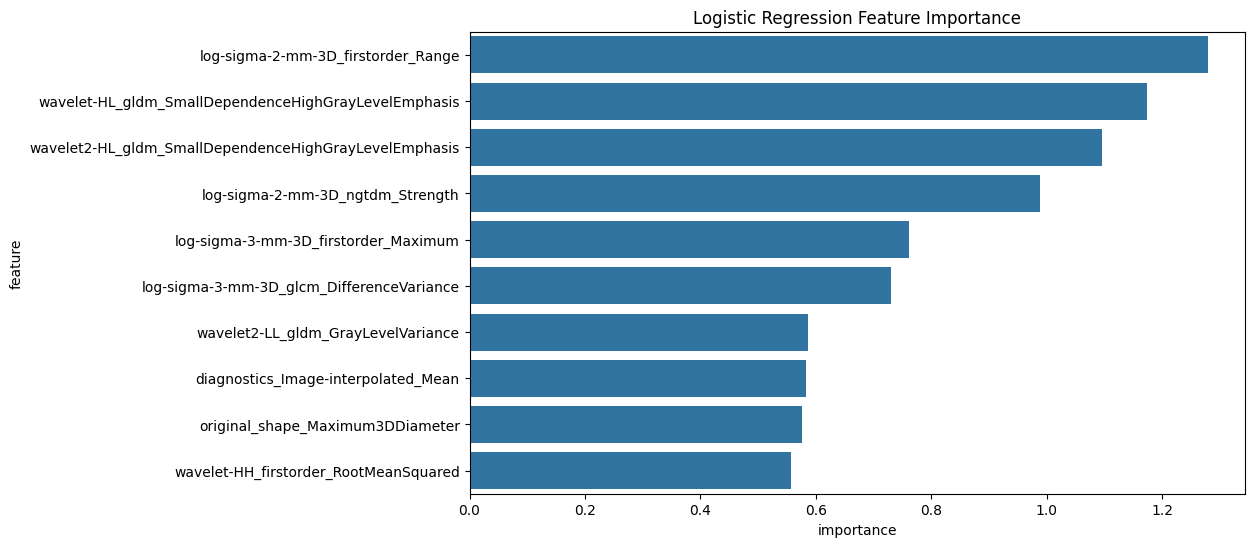


===== Training and Evaluating: Random Forest =====

Cross-validation scores (roc_auc): [0.63078704 0.61226852 0.63425926 0.5021978  0.58928571]
Mean cross-validation score (roc_auc): 0.5937596662596663

--- Random Forest Test Set Evaluation ---
Accuracy: 0.7666666666666667
Precision: 0.6
Recall: 0.2
F1-score: 0.3
AUC-ROC: 0.6207407407407407
Confusion Matrix:
 [[43  2]
 [12  3]]

Feature Importances:
| feature                                               |   importance |
|:------------------------------------------------------|-------------:|
| log-sigma-3-mm-3D_firstorder_Maximum                  |    0.115924  |
| diagnostics_Image-interpolated_Mean                   |    0.115871  |
| original_shape_Maximum3DDiameter                      |    0.11087   |
| wavelet-HL_gldm_SmallDependenceHighGrayLevelEmphasis  |    0.105252  |
| log-sigma-2-mm-3D_firstorder_Range                    |    0.100544  |
| log-sigma-3-mm-3D_glcm_DifferenceVariance             |    0.099874  |
| log-sigma-

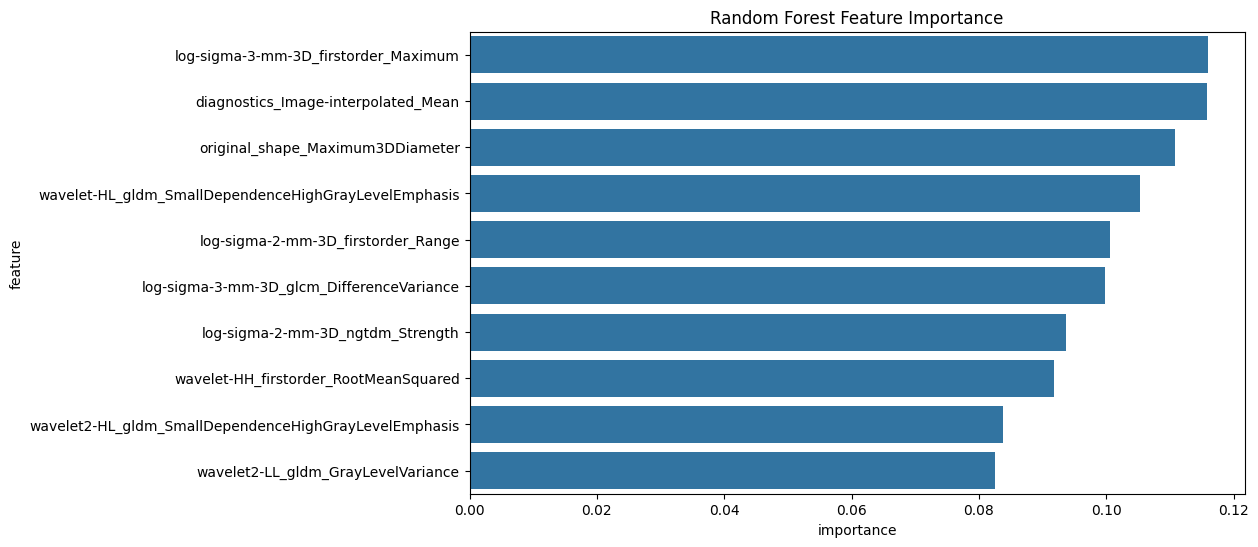


===== Training and Evaluating: SVM =====

Cross-validation scores (roc_auc): [0.68287037 0.69675926 0.7662037  0.52747253 0.62857143]
Mean cross-validation score (roc_auc): 0.6603754578754579

--- SVM Test Set Evaluation ---
Accuracy: 0.75
Precision: 0.0
Recall: 0.0
F1-score: 0.0
AUC-ROC: 0.5792592592592594
Confusion Matrix:
 [[45  0]
 [15  0]]
Feature importances not available for SVM.

===== Training and Evaluating: XGBoost =====


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:16:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:16:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:16:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py


Cross-validation scores (roc_auc): [0.67361111 0.62731481 0.54398148 0.56263736 0.62619048]
Mean cross-validation score (roc_auc): 0.6067470492470493

--- XGBoost Test Set Evaluation ---
Accuracy: 0.7666666666666667
Precision: 0.5555555555555556
Recall: 0.3333333333333333
F1-score: 0.4166666666666667
AUC-ROC: 0.5985185185185184
Confusion Matrix:
 [[41  4]
 [10  5]]

Feature Importances:
| feature                                               |   importance |
|:------------------------------------------------------|-------------:|
| diagnostics_Image-interpolated_Mean                   |    0.153196  |
| log-sigma-3-mm-3D_firstorder_Maximum                  |    0.138982  |
| original_shape_Maximum3DDiameter                      |    0.124222  |
| wavelet-HL_gldm_SmallDependenceHighGrayLevelEmphasis  |    0.11138   |
| log-sigma-2-mm-3D_firstorder_Range                    |    0.104056  |
| log-sigma-3-mm-3D_glcm_DifferenceVariance             |    0.0875508 |
| wavelet-HH_firstorder_R

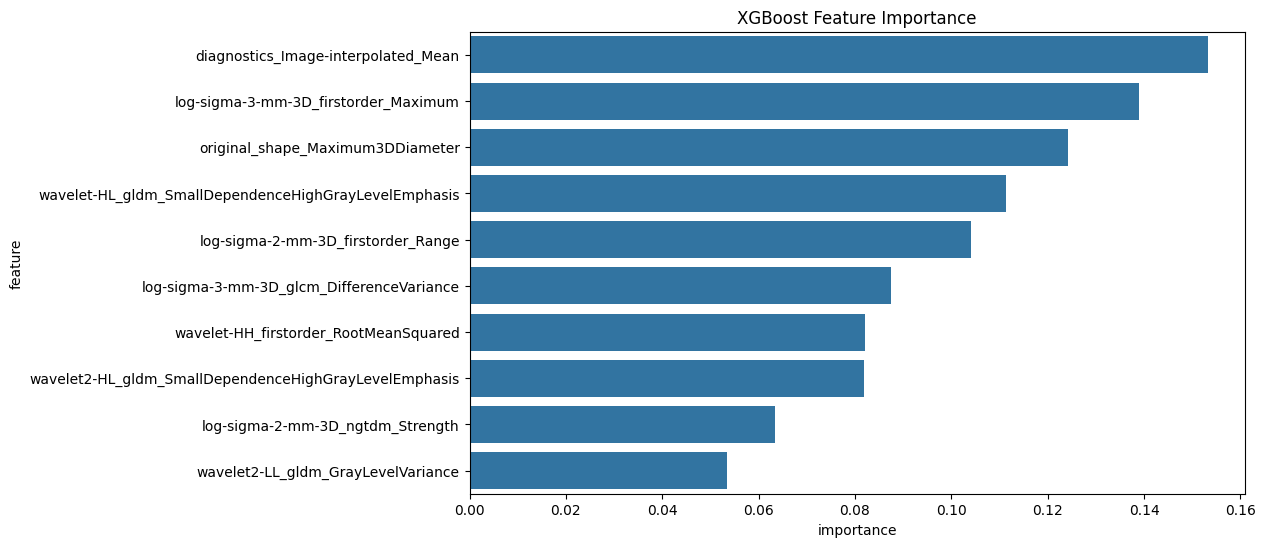


===== Training and Evaluating: LightGBM =====
[LightGBM] [Info] Number of positive: 49, number of negative: 142
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000118 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 653
[LightGBM] [Info] Number of data points in the train set: 191, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.256545 -> initscore=-1.064007
[LightGBM] [Info] Start training from score -1.064007
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warni

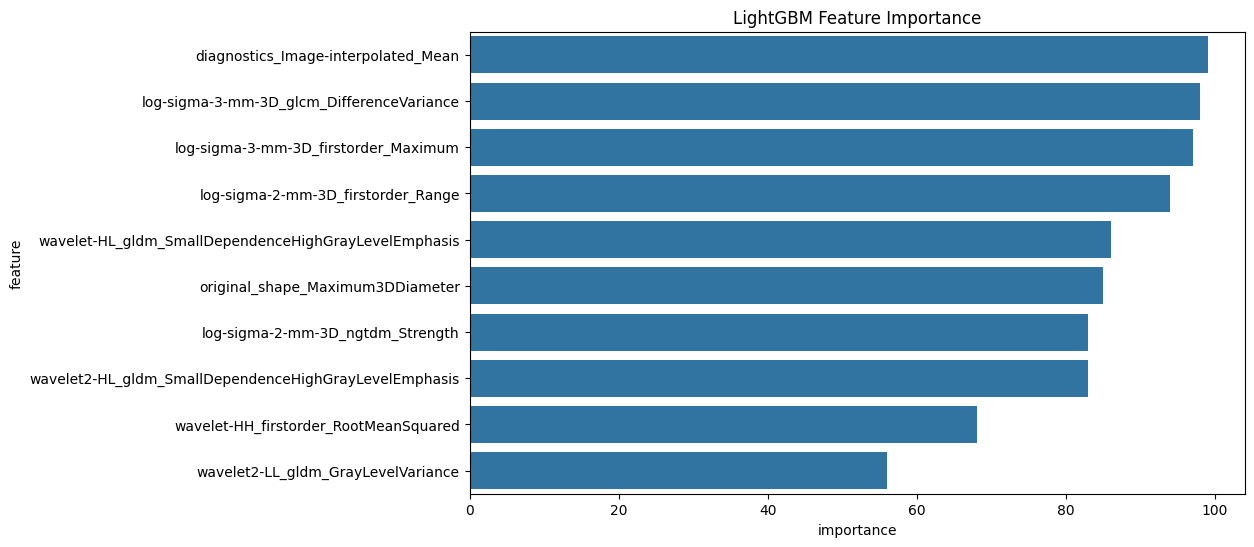


===== Training and Evaluating: CatBoost =====

Cross-validation scores (roc_auc): [0.62731481 0.63657407 0.68287037 0.54285714 0.65      ]
Mean cross-validation score (roc_auc): 0.6279232804232804

--- CatBoost Test Set Evaluation ---
Accuracy: 0.75
Precision: 0.5
Recall: 0.13333333333333333
F1-score: 0.21052631578947367
AUC-ROC: 0.5896296296296296
Confusion Matrix:
 [[43  2]
 [13  2]]

Feature Importances:
| feature                                               |   importance |
|:------------------------------------------------------|-------------:|
| log-sigma-3-mm-3D_firstorder_Maximum                  |     12.7031  |
| log-sigma-3-mm-3D_glcm_DifferenceVariance             |     12.6283  |
| diagnostics_Image-interpolated_Mean                   |     11.8555  |
| original_shape_Maximum3DDiameter                      |     10.9736  |
| log-sigma-2-mm-3D_firstorder_Range                    |      9.42587 |
| wavelet-HH_firstorder_RootMeanSquared                 |      9.35764 |
| wa

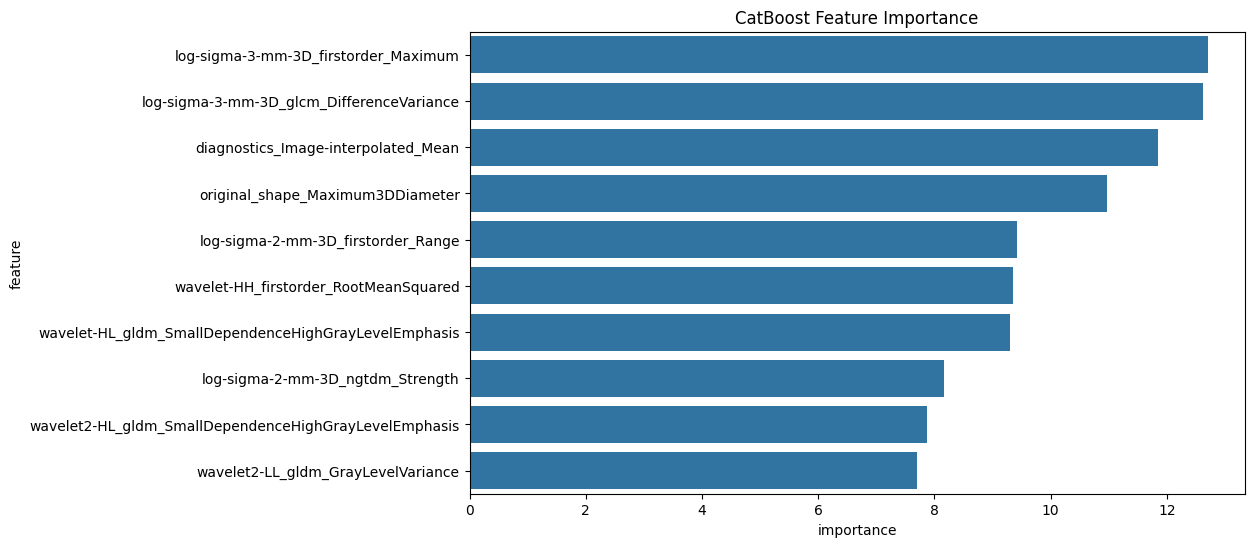

In [14]:
# @title Entrenamiento y Evaluación de Múltiples Modelos (Clinically Significant)

# --- Define the models ---
models_cs = {
    'Logistic Regression': LogisticRegression(solver='liblinear', random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42),  # Add probability=True for ROC AUC
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42), #Added
    'LightGBM': LGBMClassifier(random_state=42), #Added
    'CatBoost': CatBoostClassifier(random_state=42, verbose=False) #Added

}

# --- Train and evaluate the models ---
results_cs = train_evaluate_multiple_models(
    X_train_processed_cs, y_train_cs, X_test_processed_cs, y_test_cs, models_cs
)


===== Clinically Significant Model =====

Cross-validation scores (roc_auc): [0.78009259 0.77777778 0.75462963 0.69010989 0.8       ]
Mean cross-validation score (roc_auc): 0.7605219780219781

--- Logistic Regression (CS) Test Set Evaluation ---
Accuracy: 0.65
Precision: 0.2
Recall: 0.13333333333333333
F1-score: 0.16
AUC-ROC: 0.49333333333333323
Confusion Matrix:
 [[37  8]
 [13  2]]

Feature Importances:
| feature                                               |   importance |
|:------------------------------------------------------|-------------:|
| log-sigma-2-mm-3D_firstorder_Range                    |     1.2787   |
| wavelet-HL_gldm_SmallDependenceHighGrayLevelEmphasis  |     1.17398  |
| wavelet2-HL_gldm_SmallDependenceHighGrayLevelEmphasis |     1.09658  |
| log-sigma-2-mm-3D_ngtdm_Strength                      |     0.988786 |
| log-sigma-3-mm-3D_firstorder_Maximum                  |     0.762111 |
| log-sigma-3-mm-3D_glcm_DifferenceVariance             |     0.730583 |
| wavel

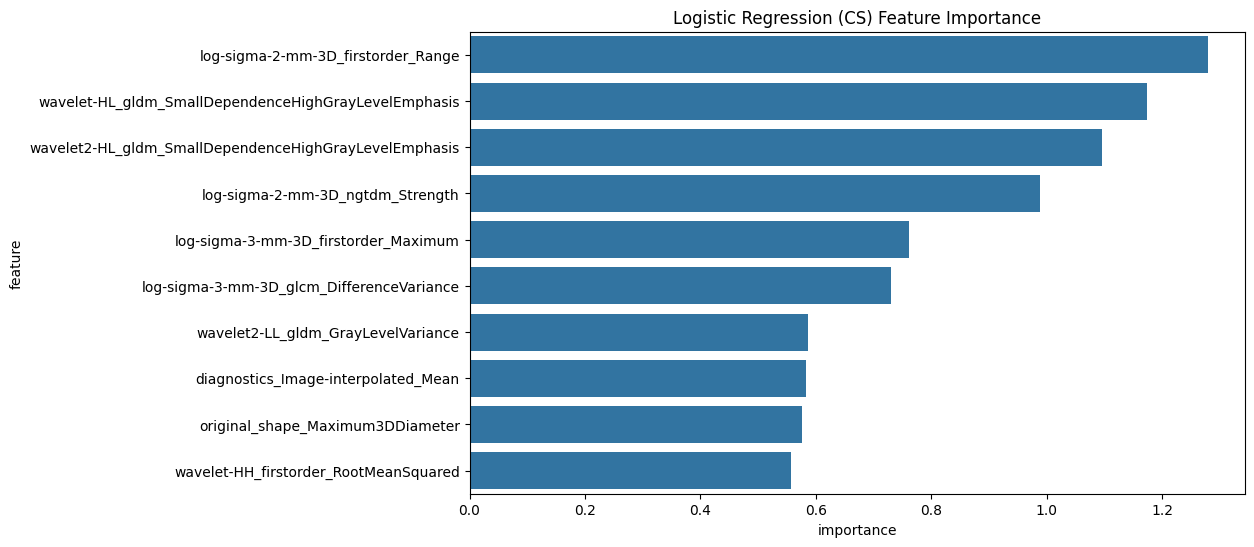

In [15]:
# @title Entrenamiento y Evaluación de Modelos

# --- Modelo para Clinically Significant ---
print("\n===== Clinically Significant Model =====")
model_cs = LogisticRegression(solver='liblinear', random_state=42)  # Or any other suitable binary classifier
trained_model_cs, cv_score_cs = train_evaluate_and_plot_importance(
    model_cs, X_train_processed_cs, y_train_cs, X_test_processed_cs, y_test_cs, model_name="Logistic Regression (CS)"
)

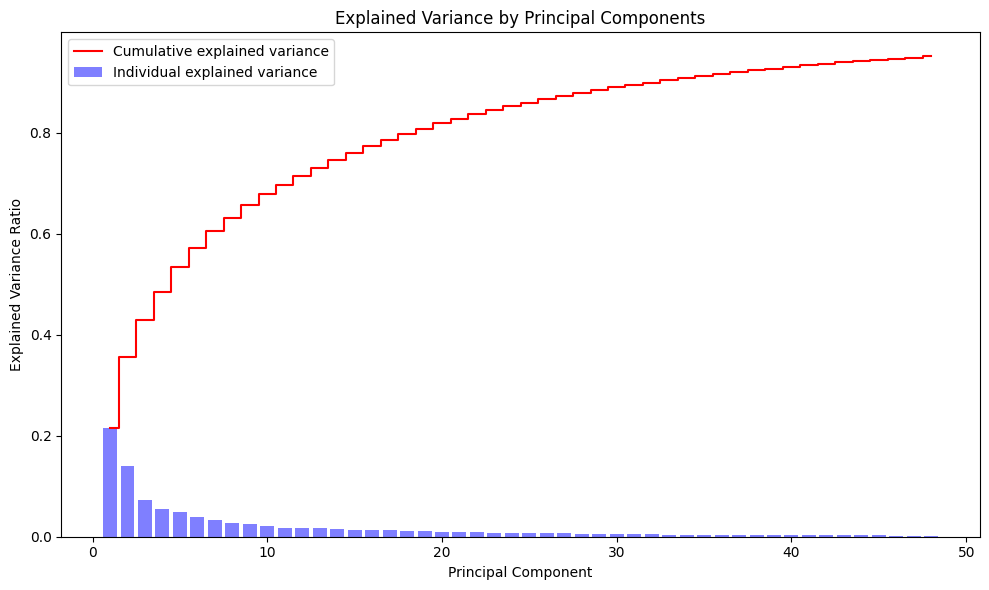

Results saved to the 'results' directory.


In [16]:
# @title Guardar Resultados (Opcional)

# Create a results directory if it doesn't exist.
import os
if not os.path.exists("results"):
    os.makedirs("results")

# --- Save Processed Data ---
X_train_processed_cs.to_csv('results/X_train_processed_cs.csv', index=False)
if X_test_processed_cs is not None:
    X_test_processed_cs.to_csv('results/X_test_processed_cs.csv', index=False)

X_train_processed_gleason.to_csv('results/X_train_processed_gleason.csv', index=False)
if X_test_processed_gleason is not None:
    X_test_processed_gleason.to_csv('results/X_test_processed_gleason.csv', index=False)

dropped_df.to_csv('results/dropped_columns.csv', index=False)

# --- Save Models (using pickle) ---
import pickle

# Save models for Clinically Significant
for model_name, model_data in results_cs.items():
    model = model_data['model']
    filename = f'results/model_cs_{model_name.replace(" ", "_").lower()}.pkl'  # Create unique filenames
    pickle.dump(model, open(filename, 'wb'))

#You can save the Gleason models in a similar way if you train them

# --- Save PCA results (if applicable)---
if results['pca'] is not None:
    pca_results = results['pca']
    pca_df = pd.DataFrame(pca_results['components'], columns=X_train_scaled.columns)
    pca_df.to_csv('results/pca_loadings.csv')
    #Guardar la varianza explicada
    explained_variance_df = pd.DataFrame({
        'Principal Component': range(1, len(pca_results['explained_variance_ratio']) + 1),
        'Explained Variance Ratio': pca_results['explained_variance_ratio'],
        'Cumulative Explained Variance': pca_results['cumulative_explained_variance']
    })
    explained_variance_df.to_csv('results/pca_explained_variance.csv', index=False)

    # Gráfico de Varianza Explicada
    plt.figure(figsize=(10, 6))
    plt.bar(range(1, len(pca_results['explained_variance_ratio']) + 1), pca_results['explained_variance_ratio'], alpha=0.5, align='center',
            label='Individual explained variance', color = 'blue')
    plt.step(range(1, len(pca_results['cumulative_explained_variance']) + 1), pca_results['cumulative_explained_variance'], where='mid',
             label='Cumulative explained variance', color = 'red')
    plt.ylabel('Explained Variance Ratio')
    plt.xlabel('Principal Component')
    plt.legend(loc='best')
    plt.title('Explained Variance by Principal Components')
    plt.tight_layout()
    plt.savefig('results/pca_explained_variance_plot.png') #Save the plot
    plt.show()


# --- Save ICA results (if applicable) ---
if results['ica'] is not None:
    ica_results = results['ica']
    ica_df = pd.DataFrame(ica_results['mixing_matrix'], index=X_train_scaled.columns)  # Use components as index
    ica_df.to_csv('results/ica_mixing_matrix.csv')  #Save the mixing matrix

print("Results saved to the 'results' directory.")